## Image sample (DDPM - guided diffusion - Diffusion beats gans)

In [18]:
# from __future__ import print_function 
import argparse
import os, sys, glob

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import PIL
import copy
import pytorch_lightning as pl
sys.path.insert(0, '../../')
from guided_diffusion.script_util import (
    seed_all,
)
import importlib

# Sample utils
sys.path.insert(0, '../')
from sample_utils import (
    ckpt_utils, 
    params_utils, 
    vis_utils, 
    file_utils, 
    img_utils, 
    inference_utils, 
    mani_utils,
    attr_mani,
)

In [19]:
# Define loading settings 
# cfg_name = "cond_img64_by_deca_arcface.yaml"
# log_dir = "cond_img64_by_deca_arcface"

# cfg_name = "UNetCond_shape_pose_light.yaml"
# log_dir = "UNetCond_shape_pose_light"

# cfg_name = "arcface_light.yaml"
# log_dir = "arcface_light"

# cfg_name = "shape_pose_light.yaml"
# log_dir = "shape_pose_light"

# cfg_name = "shape_pose_light.yaml"
# log_dir = "shape_pose_light"
# cfg_name = "all_reduce_mult_SharedConv_shaded1.yaml"
# log_dir = "all_reduce_mult_SharedConv_shaded1"
# cfg_name = "all_reduce_nomult.yaml"
# log_dir = "all_reduce_nomult"

cfg_name = "DuplicateUNetCond_lastconv=False.yaml"
log_dir = "DuplicateUNetCond_lastconv=False"
set_ = "valid"
seed = 47
seed_all(seed)
if set_ == 'itw':
    img_dataset_path = "../../itw_images/aligned/"
elif set_ == 'train' or set_ == 'valid':
    img_dataset_path = f"/data/mint/ffhq_256_with_anno/ffhq_256/{set_}/"
else: raise NotImplementedError

# Checkpoint loader
step = "300000"
ckpt_selector = "ema"
ckpt_loader = ckpt_utils.CkptLoader(log_dir=log_dir, cfg_name=cfg_name)
cfg = ckpt_loader.cfg
model_dict, diffusion = ckpt_loader.load_model(ckpt_selector=ckpt_selector, step=step)


[#] Model Path :  ['/data/mint/model_logs_mount/v12/DuplicateUNetCond_lastconv=False/']
['/home/mint/guided-diffusion/config/Duplicate_UNet/DuplicateUNetCond_lastconv=False.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/Duplicate_UNet/DuplicateUNetCond_lastconv=False.yaml')

[#] Available ckpt :  ['_000000.pt', '_050000.pt', '_100000.pt', '_150000.pt', '_200000.pt', '_250000.pt', '_300000.pt']
[#] Loading.../data/mint/model_logs_mount/v12/DuplicateUNetCond_lastconv=False//ImgCond_ema_0.9999_300000.pt


In [20]:
# importlib.reload()
if False:

    batch_size = 20
    # Load params
    params_set = params_utils.get_params_set(set=set_, cfg=cfg)

    rand_idx = np.random.choice(a=range(len(list(params_set.keys()))), replace=False, size=batch_size)
    img_path = file_utils._list_image_files_recursively(img_dataset_path)
    img_path = [img_path[r] for r in rand_idx]
    img_name = [path.split('/')[-1] for path in img_path]

    # Load condition & Images into model_kwargs
    model_kwargs = mani_utils.load_condition(params_set, img_name)
    images = mani_utils.load_image(all_path=img_path, cfg=cfg, vis=True)['image']
    model_kwargs.update({'image_name':img_name, 'image':images})
    base_idx = 11
    mode = {'init_noise':'vary_noise', 'cond_params':'vary_cond'}
    interchange = None

    # Input 
    init_noise = inference_utils.get_init_noise(n=batch_size, mode='fixed_noise', img_size=cfg.img_model.image_size, device=ckpt_loader.device)
    cond = model_kwargs.copy()

    # Finalize the cond_params
    key_cond_params = mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params)
    cond = mani_utils.create_cond_params(cond=cond, key=key_cond_params)
    cond = params_utils.preprocess_cond(deca_params=cond, k='light', cfg=cfg)
    cond = inference_utils.to_tensor(cond, key=['cond_params', 'light', 'image'], device=ckpt_loader.device)
    img_tmp = cond['image'].clone()

    # Reverse
    pl_reverse_sampling = inference_utils.PLReverseSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_reverse_sample_loop, cfg=cfg)
    reverse_ddim_sample = pl_reverse_sampling(x=cond['image'], model_kwargs=cond)

    # Forward
    pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
    sample_ddim = pl_sampling(noise=reverse_ddim_sample['img_output'], model_kwargs=cond)

    # Visualization
    fig = vis_utils.plot_sample(img=cond['image'], reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])
    plt.show()

# Linear Classifier

In [21]:
# Loading params
params_set = params_utils.get_params_set(set=set_, cfg=cfg)

Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-light-anno.txt
Key=> faceemb : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-faceemb-anno.txt


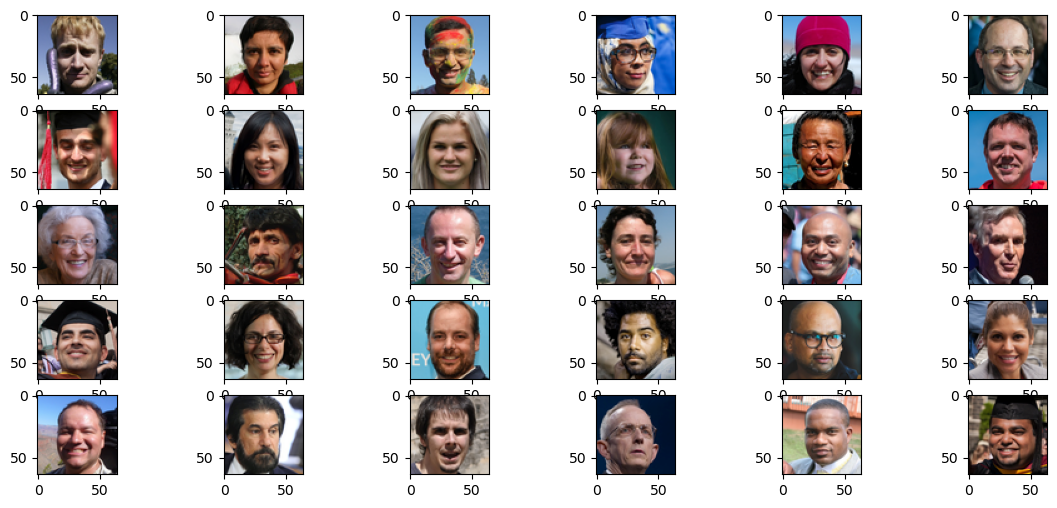

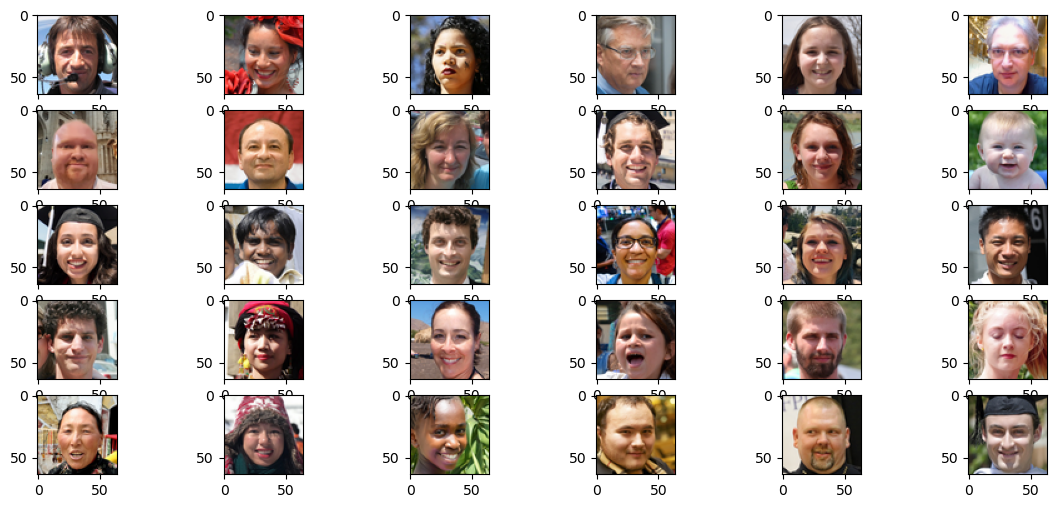

In [22]:
'''
Prepare data
 - Positive class = destination = 1
 - Negative class = source = 0
'''
importlib.reload(attr_mani)
k = 100
# Source = label as 0
# src_ref = '61048.jpg'
src_ref = '60065.jpg'
ref_params = params_set[src_ref]['light']
src_images, src_params_dict, src_weight = attr_mani.retrieve_topk_params(params_set=params_set, cfg=cfg, ref_params=ref_params, img_dataset_path=img_dataset_path, k=k, dist_type='l1')
src_label = th.zeros(k)
# Destination = label as 1
# dst_ref = '61339.jpg'
dst_ref = '60182.jpg'
ref_params = params_set[dst_ref]['light']
dst_images, dst_params_dict, dst_weight = attr_mani.retrieve_topk_params(params_set=params_set, cfg=cfg, ref_params=ref_params, img_dataset_path=img_dataset_path, k=k, dist_type='l1')
dst_label = th.ones(k)

src_params = [v['light'] for k, v in src_params_dict.items()]
dst_params = [v['light'] for k, v in dst_params_dict.items()]
src_params = np.stack(src_params, axis=0)
dst_params = np.stack(dst_params, axis=0)

input = np.concatenate((src_params, dst_params), axis=0)
input = th.tensor(input)
gt = th.cat((src_label, dst_label))[..., None]
weighted_loss = th.cat((src_weight, dst_weight))[..., None]


In [23]:
# Train the Linear Classifier
seed_all(47)
cls_model = attr_mani.LinearClassifier(cfg).cuda()
cls_model.train(gt=gt.cuda(), input=input.float().cuda(), n_iters=10000, weighted_loss=weighted_loss.cuda(), progress=True)
# cls_model.train(gt=gt.cuda(), input=input.float().cuda(), n_iters=10000, weighted_loss=None, progress=True)

print("[#] Parameters")
for k, v in cls_model.named_parameters():
    print(k, v, v.shape)

print("[#] Evaluation")
cls_model.evaluate(gt=gt.cuda(), input=input.float().cuda())

print(f"[#] Interpolate Direction = {th.nn.functional.normalize(cls_model.cls.weight, dim=1)}")

[#] Training Linear Classifier with iterations=10000, samples_size=200


[#] Loss = 6.369396487571066e-06: 100%|██████████| 10000/10000 [00:04<00:00, 2156.25it/s]

[#] Parameters
cls.weight Parameter containing:
tensor([[ 0.66199,  0.65587,  0.81851, -2.41009, -2.52096, -2.43648, -1.70244,
         -1.95805, -2.07358,  1.87088,  1.73713,  1.83209, -2.44900, -2.44435,
         -2.49420, -1.91175, -1.89477, -2.16479, -0.61699, -0.54070, -0.55174,
         -2.60768, -2.75918, -2.70378, -2.89035, -2.70281, -2.63760]],
       device='cuda:0', requires_grad=True) torch.Size([1, 27])
cls.bias Parameter containing:
tensor([-1.17273], device='cuda:0', requires_grad=True) torch.Size([1])
[#] Evaluation
[#] Accuracy = 98.99999237060547
[#] Interpolate Direction = tensor([[ 0.06147,  0.06090,  0.07600, -0.22378, -0.23408, -0.22623, -0.15808,
         -0.18181, -0.19254,  0.17372,  0.16130,  0.17011, -0.22740, -0.22697,
         -0.23159, -0.17751, -0.17594, -0.20101, -0.05729, -0.05021, -0.05123,
         -0.24213, -0.25620, -0.25105, -0.26838, -0.25096, -0.24491]],
       device='cuda:0', grad_fn=<DivBackward0>)


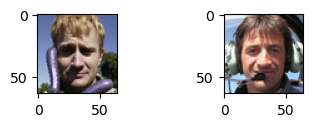

[#] Condition build from parameters in  ['shape', 'pose', 'exp', 'cam', 'faceemb']
(2, 671)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

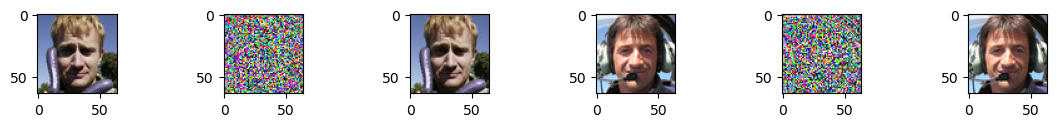

In [24]:
'''
[#] Load condition, image
'''
importlib.reload(mani_utils)
importlib.reload(params_utils)
itp_set = ['light']
img_name = [src_ref, dst_ref]
model_kwargs = mani_utils.load_condition(params_set, img_name=img_name)
images = mani_utils.load_image_by_name(img_name=img_name, img_dataset_path=img_dataset_path, cfg=cfg, vis=True)['image']
model_kwargs.update({'image_name':img_name, 'image':images})
cond = model_kwargs.copy()

# Finalize the cond_params
key_cond_params = mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params)
cond = model_kwargs.copy()
cond = mani_utils.create_cond_params(cond=cond, key=key_cond_params)
cond['light'] = params_utils.preprocess_cond(deca_params=cond, k='light', cfg=cfg)
cond = inference_utils.to_tensor(cond, key=['cond_params', 'light', 'image'], device=ckpt_loader.device)
img_tmp = cond['image'].clone()

'''
Reverse & Forward process
'''
# Reverse
pl_reverse_sampling = inference_utils.PLReverseSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_reverse_sample_loop, cfg=cfg)
reverse_ddim_sample = pl_reverse_sampling(x=cond['image'], model_kwargs=cond)

# Forward
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_ddim = pl_sampling(noise=reverse_ddim_sample['img_output'], model_kwargs=cond)

# Visualization
fig = vis_utils.plot_sample(img=cond['image'], reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])
plt.show()


[#] Condition build from parameters in  ['shape', 'pose', 'exp', 'cam', 'faceemb']
(10, 671)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

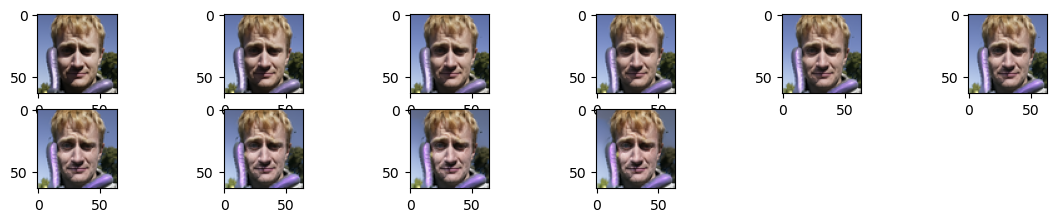

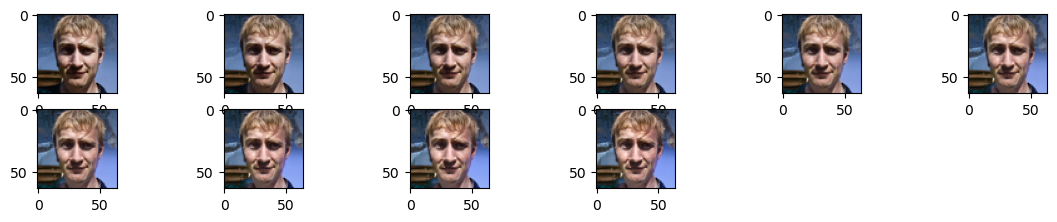

In [25]:
'''
[#] With classifier interpolation
'''
importlib.reload(mani_utils)
n = 10
itp_dir = th.nn.functional.normalize(cls_model.cls.weight, dim=1).detach().cpu().numpy()

cond = model_kwargs.copy()
interp_cond = mani_utils.interp_by_dir(cond.copy(), src_idx=0, itp_name='light', direction=itp_dir, n_step=n)
cond = mani_utils.repeat_cond_params(cond, base_idx=0, n=n, key=mani_utils.without(cfg.param_model.params_selector, ['light']))
cond.update(interp_cond)
key_cond_params = mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params)
cond = mani_utils.create_cond_params(cond=cond, key=key_cond_params)
cond['light'] = params_utils.preprocess_cond(deca_params=cond, k='light', cfg=cfg)
cond = inference_utils.to_tensor(cond, key=['cond_params', 'light'], device=ckpt_loader.device)

# Forward
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_from_rev = pl_sampling(noise=th.cat([reverse_ddim_sample['img_output'][[0]]]*n, dim=0), model_kwargs=cond)

# Forward with N(0, 1) noise
init_noise = inference_utils.get_init_noise(n=n, mode='fixed_noise', img_size=cfg.img_model.image_size, device=ckpt_loader.device)
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_from_gauss = pl_sampling(noise=init_noise, model_kwargs=cond)

fig = vis_utils.plot_sample(img=sample_from_rev['img_output'])
plt.show()
fig = vis_utils.plot_sample(img=sample_from_gauss['img_output'])
plt.show()

[#] Condition build from parameters in  ['shape', 'pose', 'exp', 'cam', 'faceemb']
(10, 671)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

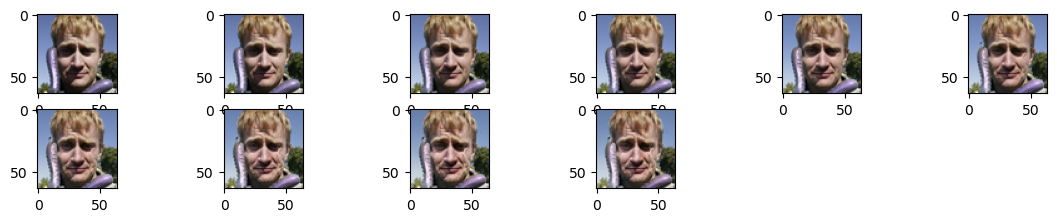

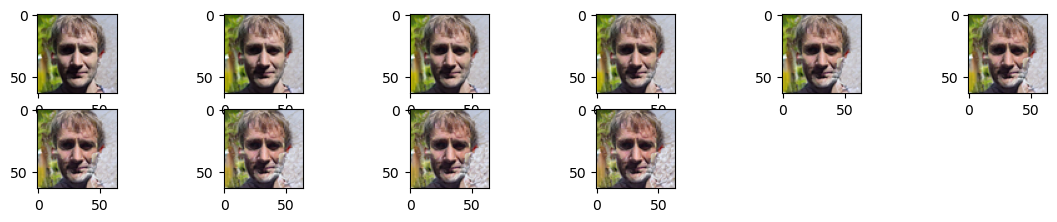

In [26]:
'''
[#] Without classifier interpolation
'''
cond = model_kwargs.copy()
interp_cond = mani_utils.iter_interp_cond(cond.copy(), interp_set=['light'], src_idx=0, dst_idx=1, n_step=n)
cond = mani_utils.repeat_cond_params(cond, base_idx=0, n=n, key=mani_utils.without(cfg.param_model.params_selector, ['light']))
cond.update(interp_cond)

# Finalize the cond_params
key_cond_params = mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params)
cond = mani_utils.create_cond_params(cond=cond, key=key_cond_params)
cond['light'] = params_utils.preprocess_cond(deca_params=cond, k='light', cfg=cfg)
cond = inference_utils.to_tensor(cond, key=['cond_params', 'light'], device=ckpt_loader.device)

# Forward
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_from_rev = pl_sampling(noise=th.cat([reverse_ddim_sample['img_output'][[0]]]*n, dim=0), model_kwargs=cond)

# Forward with N(0, 1) noise
init_noise = inference_utils.get_init_noise(n=n, mode='fixed_noise', img_size=cfg.img_model.image_size, device=ckpt_loader.device)
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_from_gauss = pl_sampling(noise=init_noise, model_kwargs=cond)

fig = vis_utils.plot_sample(img=sample_from_rev['img_output'])
plt.show()
fig = vis_utils.plot_sample(img=sample_from_gauss['img_output'])
plt.show()